# Music

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import music21 # must import before fastai. otherwise stream.show() encounters elementtree error
from fastai.text import *

In [3]:
from fastai_data import MusicTokenizer
from encode_data import *
from midi_data import *
from gpt import gpt

In [4]:
# c = music21.corpus.parse(music21.corpus.chorales.Iterator(returnType='filename')[55]) c.show()

In [5]:
music21.environment.get('musicxmlPath')

PosixPath('/usr/bin/musescore')

In [6]:
path = Path('data/midi/v6/midi_transcribe/shortdur/')
get_files(path/'models/fastai/txl', recurse=True)

[PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/pop/2_ep10_run2_bptt256_mem1024_best.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/pop/2_ep10_run2_bptt256_mem1024.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/pop/2_ep7_rebuild.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/pop/2_ep7_rebuild_best.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/pop/1_ep20_best.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/clc/1_ep1_test_best.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/clc/2_ep50_run2_best.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/clc/3_ep1_run2_bptt256_mem1024_bias.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/clc/3_ep1_run2_bptt256_mem1024_bias_best.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/clc/2_ep50_ru

In [7]:
model_path = 'fastai/txl/hook/2_ep2_run2_bptt256_mem1024_sanity_test'

https://hpml2018.github.io/HPML2018_1.pdf

This paper suggests linear scaling rule does not work with RNNs. 3e-3 seems to be the magical number for 2k-8k

However, they didn't use schedule warmup, so I doubt they optimized the learning rate enough

In [8]:
bs=8
bptt=500

In [9]:
data = TextLMDataBunch.load(path, cache_name='tmp/hook', bs=bs, bptt=bptt)
data.valid_ds.x.processor[0] = TokenizeProcessor(tokenizer=MusicTokenizer())
t = data.train_ds[0][0]
t.text[:50], t.data

('xxbos || t1 nG3 t1 || t0 nF#3 t1 || t0 nA2 t1 || t',
 array([ 2,  9,  8, 17, ..., 43, 29, 57, 29]))

In [10]:
vocab = data.train_ds.vocab
vocab_size = len(vocab.itos); vocab_size

507

In [11]:
data.train_dl.shuffle

True

In [12]:
data.train_dl.dl.shuffle

True

In [13]:
vocab.stoi

defaultdict(int,
            {'xxunk': 0,
             'xxpad': 1,
             'xxbos': 2,
             'xxfld': 3,
             'xxmaj': 4,
             'xxup': 5,
             'xxrep': 6,
             'xxwrep': 7,
             't1': 8,
             '||': 9,
             't2': 10,
             't4': 11,
             't0': 12,
             't3': 13,
             'nC4': 14,
             'nE4': 15,
             'nG4': 16,
             'nG3': 17,
             'nD4': 18,
             'nA3': 19,
             'nA4': 20,
             't8': 21,
             'nC5': 22,
             'nE3': 23,
             'nC3': 24,
             'nB3': 25,
             'nE5': 26,
             'nD3': 27,
             'nF4': 28,
             't16': 29,
             'nD5': 30,
             'nC2': 31,
             'nB4': 32,
             'nG2': 33,
             'nF#2': 34,
             't6': 35,
             'nA2': 36,
             't5': 37,
             'nF3': 38,
             'nE2': 39,
             'nD2': 40,
 

### Load Learner

In [13]:
cuda_enabled = torch.cuda.is_available()

In [14]:
# tfmerXL_lm_config['ctx_len'] = 512
# tfmerXL_lm_config['mem_len'] = 512

In [15]:
learn = language_model_learner(data, TransformerXL, clip=0.5)

/home/ubuntu/fastai/fastai/text/learner.py:198: UserWarning: There are no pretrained weights for that architecture yet!
  warn("There are no pretrained weights for that architecture yet!")


In [16]:
learn = learn.load(model_path, strict=False)

## Done

In [17]:
# learn.show_results(rows=5, max_len=25)

In [18]:
# idx = 3
# idx = 8
seed_len = 80
files = get_files(path/'hooktheory', recurse=True)
# file = files[idx]; file
file = np.random.choice(files); file

PosixPath('data/midi/v6/midi_transcribe/shortdur/hooktheory/pianoroll/g/green-day/the-death-of-st-jimmy/chorus_key.txt')

In [19]:
# best = Path('data/midi/midi_transcribe_v3_shortdur/hooktheory/pianoroll/e/elton-john/tiny-dancer/pre-chorus_key.txt')

In [20]:
with open(file, 'r') as f:
    txt_out = f.read()
notes = txt_out.split(' ')
seed = ' '.join(notes[:seed_len]); len(notes), seed


(200,
 '|| t12 nE5 t2 || t1 nG5 t2 || t1 nA2 t12 nC3 t12 nE3 t12 nA5 t4 || t11 nG3 t4 nB3 t4 nD4 t4 nG5 t2 || t1 nE5 t2 || t1 nC3 t16 nE3 t16 nG3 t16 nE5 t4 || t11 nE5 t2 || t1 nG5 t2 || t1 nA2 t12 nC3 t12 nE3 t12 nA5 t4 || t3 nA5 t4 || t3 nA5 t3 || t2 nG5 t3 || t0 nG3 t4 nB3 t4 nD4 t4')

In [21]:
ns = str2stream(seed)
ns.show('midi')

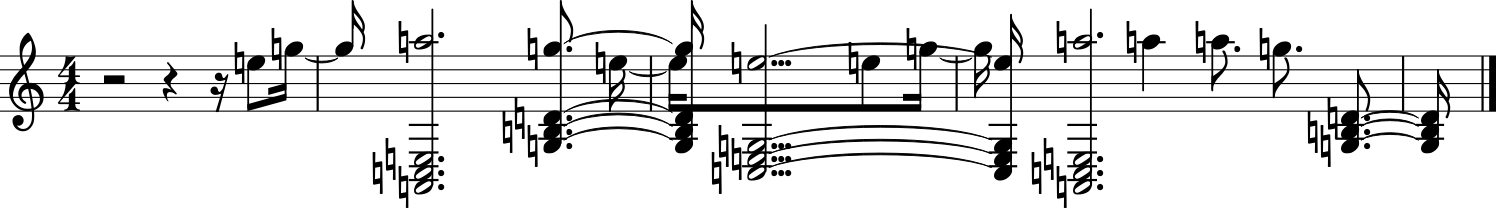

In [22]:
ns = str2stream(seed).show()

In [23]:
seed

'|| t12 nE5 t2 || t1 nG5 t2 || t1 nA2 t12 nC3 t12 nE3 t12 nA5 t4 || t11 nG3 t4 nB3 t4 nD4 t4 nG5 t2 || t1 nE5 t2 || t1 nC3 t16 nE3 t16 nG3 t16 nE5 t4 || t11 nE5 t2 || t1 nG5 t2 || t1 nA2 t12 nC3 t12 nE3 t12 nA5 t4 || t3 nA5 t4 || t3 nA5 t3 || t2 nG5 t3 || t0 nG3 t4 nB3 t4 nD4 t4'

In [24]:
# full song
str2stream(' '.join(notes)).show('midi')

### Debugging

In [25]:
def _select_hidden(model, idxs):
    if isinstance(model[0], TransformerXL):
        model[0].hidden = [h[idxs,:,:] for h in model[0].hidden]
    else:
        model[0].hidden = [(h[0][:,idxs,:],h[1][:,idxs,:]) for h in model[0].hidden]
        model[0].bs = len(idxs)


## Beam search

In [28]:
import pdb

In [29]:
self = learn

In [30]:
text = seed

In [31]:
ds = self.data.single_dl.dataset
self.model.reset()
xb, yb = self.data.one_item(text)
start_idx = xb.clone()
nodes = None
scores = xb.new_ones(1).float()

In [36]:
xb = xb.repeat(10, 1)

In [37]:
k = 0

In [38]:
beam_sz = 20

In [39]:
top_k = 10

In [40]:
self.model[0].hidden[0].shape[0], xb.shape[0]

(0, 10)

In [41]:
if self.model[0].hidden[0].shape[0] != xb.shape[0]: 
    print('REsetting')
    self.model.reset()

REsetting


In [42]:
out = F.log_softmax(self.model(xb)[0][:,-1], dim=-1)
values, indices = out.topk(top_k, dim=-1)
scores = (-values * scores[:,None]).view(-1)

In [43]:
self.model[0].hidden[0].shape, xb.shape

(torch.Size([10, 80, 410]), torch.Size([10, 80]))

In [44]:
# indices_idx = torch.arange(0,nodes.size(0))[:,None].expand(nodes.size(0), top_k).contiguous().view(-1)
# sort_idx = scores.argsort()[:beam_sz]
# scores = scores[sort_idx]
# nodes = torch.cat([nodes[:,None].expand(nodes.size(0),top_k,nodes.size(1)),
#                    indices[:,:,None].expand(nodes.size(0),top_k,1),], dim=2)
# nodes = nodes.view(-1, nodes.size(2))[sort_idx]

AttributeError: 'NoneType' object has no attribute 'size'

In [75]:
if nodes is None: 
    nodes = indices[0][:,None]
    self.model[0].select_hidden([0] * nodes.size(0))
else:
    indices_idx = torch.arange(0,nodes.size(0))[:,None].expand(nodes.size(0), top_k).contiguous().view(-1)
    sort_idx = scores.argsort()[:beam_sz]
    scores = scores[sort_idx]
    nodes = torch.cat([nodes[:,None].expand(nodes.size(0),top_k,nodes.size(1)),
                       indices[:,:,None].expand(nodes.size(0),top_k,1),], dim=2)
    nodes = nodes.view(-1, nodes.size(2))[sort_idx]
    self.model[0].select_hidden(indices_idx[sort_idx])
xb = nodes[:,-1][:,None]

In [76]:
k += 1

In [79]:
nodes

tensor([[27, 46],
        [36, 46],
        [59, 46],
        [33, 33],
        [46, 46],
        [62, 46],
        [24, 46],
        [40, 33],
        [40, 46],
        [38, 34],
        [38, 46],
        [62, 33],
        [24, 33],
        [33, 46],
        [34, 24],
        [38, 24],
        [34, 33],
        [34, 46],
        [27, 33],
        [46, 34]], device='cuda:0')

In [46]:
xb.shape

torch.Size([10, 1])

In [81]:
indices[0]

torch.Size([10, 10])

In [83]:
indices[0][:,None].shape

torch.Size([10, 1])

In [39]:
with torch.no_grad():
    for k in range(n_words):
        out = F.log_softmax(self.model(xb)[0][:,-1], dim=-1)
        values, indices = out.topk(top_k, dim=-1)
        scores = (-values * scores[:,None]).view(-1)
        if nodes is None: 
            nodes = indices[0][:,None]
            _select_hidden(self.model, [0] * nodes.size(0))
        else:
            indices_idx = torch.arange(0,nodes.size(0))[:,None].expand(nodes.size(0), top_k).contiguous().view(-1)
            sort_idx = scores.argsort()[:beam_sz]
            scores = scores[sort_idx]
            nodes = torch.cat([nodes[:,None].expand(nodes.size(0),top_k,nodes.size(1)),
                               indices[:,:,None].expand(nodes.size(0),top_k,1),], dim=2)
            nodes = nodes.view(-1, nodes.size(2))[sort_idx]
            _select_hidden(self.model, indices_idx[sort_idx])
        xb = nodes[:,-1][:,None]
#             pdb.set_trace()
if temperature != 1.: scores.div_(temperature)
node_idx = torch.multinomial(1-scores, 1).item()
return text + sep + sep.join(decoder(self.data.vocab.textify([i.item() for i in nodes[node_idx]], sep=None)))

NameError: name 'n_words' is not defined

In [61]:
nodes.shape

torch.Size([10, 1])

In [52]:
learn.model[0].hidden[0].shape

torch.Size([10, 1, 410])

In [65]:
indices.shape

torch.Size([10, 10])

In [92]:
def beam_search(self, text:str, n_words:int, top_k:int=10, beam_sz:int=1000, temperature:float=1., sep:str=' ',
                decoder=decode_spec_tokens):
    "Return the `n_words` that come after `text` using beam search."
    ds = self.data.single_dl.dataset
    self.model.reset()
    xb, yb = self.data.one_item(text)
    nodes = None
    xb = xb.repeat(top_k, 1)
    nodes = xb.clone()
    scores = xb.new_ones(1).float()
    with torch.no_grad():
        for k in progress_bar(range(n_words), leave=False):
            out = F.log_softmax(self.model(xb)[0][:,-1], dim=-1)
            values, indices = out.topk(top_k, dim=-1)
            scores = (-values * scores[:,None]).view(-1)
            indices_idx = torch.arange(0,nodes.size(0))[:,None].expand(nodes.size(0), top_k).contiguous().view(-1)
            sort_idx = scores.argsort()[:beam_sz]
            scores = scores[sort_idx]
            nodes = torch.cat([nodes[:,None].expand(nodes.size(0),top_k,nodes.size(1)),
                               indices[:,:,None].expand(nodes.size(0),top_k,1),], dim=2)
            nodes = nodes.view(-1, nodes.size(2))[sort_idx]
            self.model[0].select_hidden(indices_idx[sort_idx])
            xb = nodes[:,-1][:,None]
    if temperature != 1.: scores.div_(temperature)
    node_idx = torch.multinomial(1-scores, 1).item()
    return sep.join(decoder(self.data.vocab.textify([i.item() for i in nodes[node_idx]], sep=None)))

In [93]:
learn.model[0].hidden[0].shape

torch.Size([1000, 150, 410])

In [94]:
p = beam_search(learn, seed, n_words=150); p

'|| t0 nA2 t16 nC3 t16 nF3 t16 nC4 t2 || t1 nD4 t2 || t1 nE4 t2 || t1 nF4 t2 || t1 nE4 t4 || t3 nD4 t2 || t1 nC4 t2 || t1 nG#2 t16 nB2 t16 nE3 t16 nD4 t4 || t3 nD4 t2 || t1 nC4 t2 || t1 nD4 t4 || t3 nG4 t4 || t3 nA2 t16 nC3 t16 nE3 t16 nE4 t16 || t15 nG2 t6 nB-2 t6 nD3 t6 || t5 nF2 t16 nA2 t16 nC3 t16 nC4 t2 || t1 nD4 t2 || t1 nE4 t2 || t1 nF4 t2 || t1 nE4 t4 || t3 nD4 t2 || t1 nC4 t2 || t1 nG#2 t16 nB2 t16 nE3 t16 nD4 t4 || t3 nD4 t2 || t1 nC4 t2 || t1 nD4 t4 || t3 nG4 t4 || t3 nA2 t16 nC3 t16 nE3 t16 nE4 t16 || t15 nG2 t6 nB-2 t6 nD3 t6 || t5 nF2 t16 nA2 t16 nC3 t16 nC4 t2 || t1 nD4 t2 || t1 nE4 t2 || t1 nF4 t2 || t1 nE4 t4 || t3 nD4 t2 || t1 nC4 t2 || t1 nG#2 t16 nB2 t16 nE3 t16 nD4 t4 || t3 nG4 t4 || t3 nE4 t4 || t3 nD4 t2 || t1 nC4 t2 || t1 nA2 t16 nC3 t16 nE3 t16 nD4 t4 || t7 nD4 t3'

In [95]:
str2stream(p).show('midi')

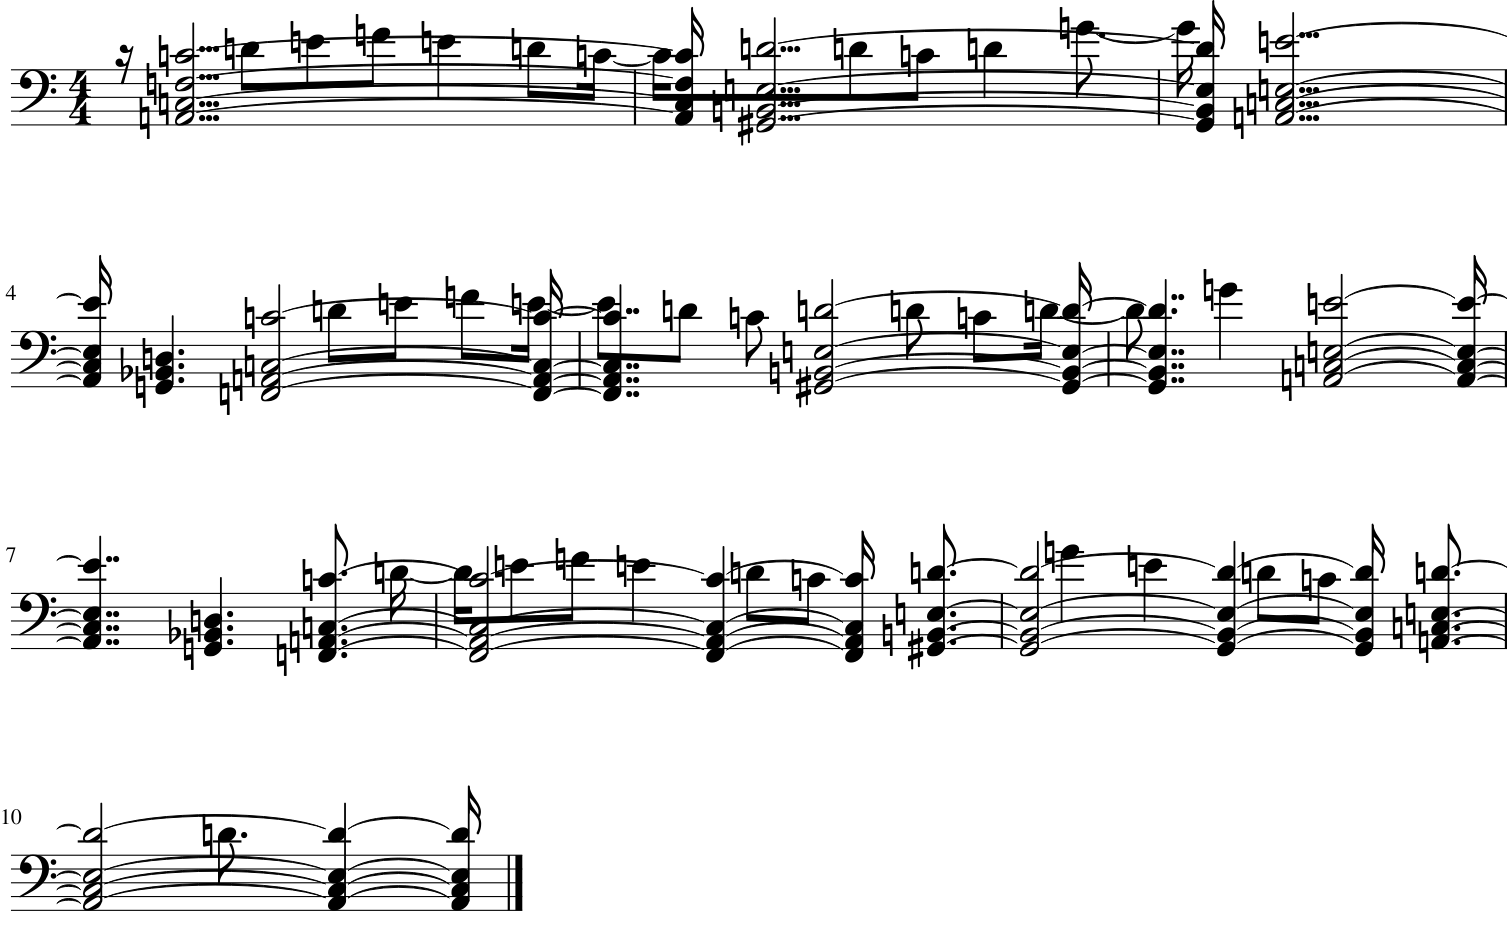

In [96]:
str2stream(p).show()

### New predict with memory

In [26]:
ob = learn.data.one_batch()

In [27]:
ob[0].shape

torch.Size([8, 500])

In [28]:
xb,yb = learn.data.one_item(seed)

In [29]:
xb.shape

torch.Size([1, 80])

In [30]:
xb.new_tensor([1,2,3])[None].shape

torch.Size([1, 3])

In [31]:
learn.model.reset()

In [32]:
[h.shape for h in learn.model[0].hidden]

[torch.Size([0]),
 torch.Size([0]),
 torch.Size([0]),
 torch.Size([0]),
 torch.Size([0]),
 torch.Size([0]),
 torch.Size([0]),
 torch.Size([0]),
 torch.Size([0]),
 torch.Size([0]),
 torch.Size([0]),
 torch.Size([0]),
 torch.Size([0])]

In [33]:
out = learn.model(xb)

In [34]:
out[0].shape

torch.Size([1, 80, 507])

In [35]:
out[1][0].shape

torch.Size([1, 80, 410])

In [39]:

def predict(self, text:str, n_words:int=1, no_unk:bool=True, temperature:float=1., min_p:float=None, sep:str=' ',
            decoder=decode_spec_tokens):
    "Return the `n_words` that come after `text`."
    ds = self.data.single_dl.dataset
    xb,yb = self.data.one_item(text)
    new_idx = []
    self.model.reset()
    for _ in progress_bar(range(n_words), leave=False):
        res = self.pred_batch(batch=(xb,yb))[0][-1]
#         if len(new_idx) == 0: _select_hidden(self.model, [0])
        if no_unk: res[self.data.vocab.stoi[UNK]] = 0.
        if min_p is not None: res[res < min_p] = 0.
        if temperature != 1.: res.pow_(1 / temperature)
        idx = torch.multinomial(res, 1).item()
        new_idx.append(idx)
        xb = xb.new_tensor([idx])[None]
    return sep.join(decoder(self.data.vocab.textify(new_idx, sep=None)))

In [40]:
p = predict(learn, seed, n_words=150); p

'|| t7 nF3 t12 nA3 t12 nC4 t12 || t11 nC3 t4 nE3 t4 nG3 t4 || t3 nF3 t4 nA3 t4 nC4 t4 || t3 nE3 t4 nG3 t4 nC4 t4 || t3 nF3 t8 nA3 t8 nC4 t8 || t7 nC3 t4 nE3 t4 nG3 t4 || t3 nF3 t4 nA3 t4 nC4 t4 || t3 nC3 t4 nE3 t4 nG3 t4 || t3 nF3 t8 nA3 t8 nC4 t8 || t7 nG3 t6 nB3 t6 nD4 t6 || t5 nB3 t6 nD4 t6 nG4 t6 || t5 nB3 t14 nD4 t14 nG4 t14 || t13 nA3 t10 nC#4 t10 nE4 t10 || t9 nA3 t3 nC#4 t3 nE4 t3 || t2 nA3 t3 nC#4 t3 nE4 t3 || t2 nA3 t2 nC#4 t2 nE4 t2 || t1 nA3 t3 nC#4 t3 nE4 t3 || t2 nA3 t3 nC#4 t3 nE4 t3 || t2 nA3 t2 nC#4 t2'

In [41]:
str2stream(p).show('midi')

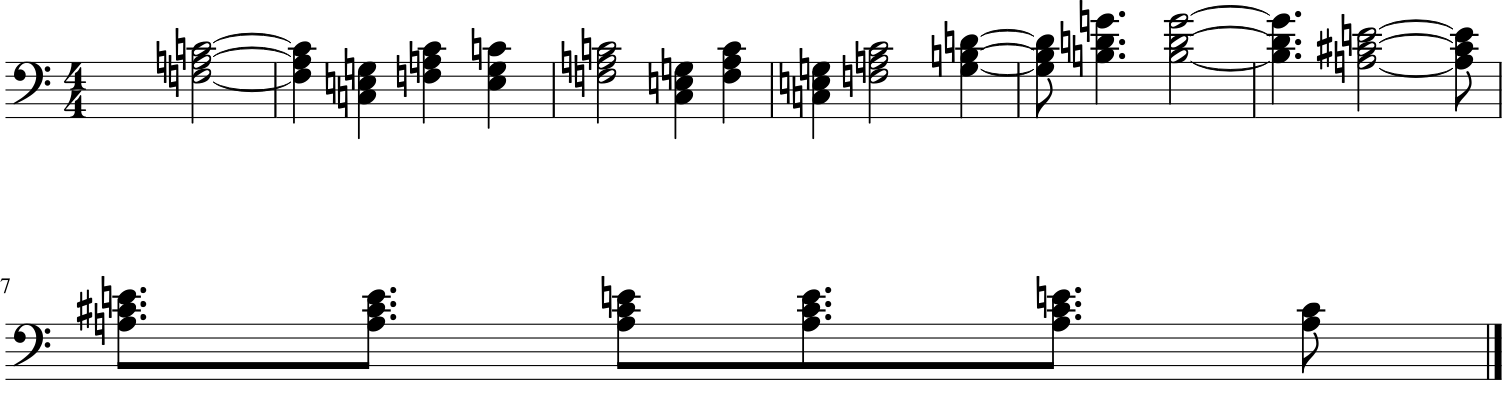

In [42]:
str2stream(p).show()

In [43]:
%debug

> <ipython-input-23-629a6ccbaffb>(3)<listcomp>()
      1 def _select_hidden(model, idxs):
      2     if isinstance(model[0], TransformerXL):
----> 3         model[0].hidden = [h[:,idxs,:] for h in model[0].hidden]
      4     else:
      5         model[0].hidden = [(h[0][:,idxs,:],h[1][:,idxs,:]) for h in model[0].hidden]

ipdb> idxs
tensor([  0,   0,   0,   0,   1,   2,   1,   2,   3,   0,   0,   0,   0,   3,
          1,   0,   1,   0,   2,   4,   2,   5,   4,   3,   3,   5,   6,   1,
          1,   1,   1,   6,   2,   2,   2,   2,   4,   1,   4,   1,   5,   2,
          3,   3,   3,   5,   3,   2,   7,   6,   3,   6,   7,   3,   8,   4,
          4,   4,   4,   8,   9,  10,  11,   5,   5,   5,   5,   4,   9,  10,
         11,   4,   7,   5,   6,   6,   6,   7,   6,  12,   5,   8,  12,   6,
         13,   8,  14,   6,  15,  13,   9,  16,  17,  18,  10,  14,   9,  11,
         10,  11,  15,  16,  17,  19,  18,  20,   7,   7,  21,   7,   7,  19,
         12,  22,  20,  12,  21,   7, 

ipdb> up
> <ipython-input-41-084a9454b555>(26)beam_search()
     24                                    indices[:,:,None].expand(nodes.size(0),top_k,1),], dim=2)
     25                 nodes = nodes.view(-1, nodes.size(2))[sort_idx]
---> 26                 _select_hidden(self.model, indices_idx[sort_idx])
     27             xb = nodes[:,-1][None,:]
     28 #             pdb.set_trace()

ipdb> nodes
*** RuntimeError: cuda runtime error (59) : device-side assert triggered at /pytorch/aten/src/THC/THCGeneral.cpp:405
ipdb> quit


In [101]:
%debug

> /home/ubuntu/fastai/fastai/text/models/transformer.py(104)_apply_attention()
    102         #parameters of the model common between all layers, mask to avoid cheating and mem the previous hidden states.
    103         bs,x_len,seq_len = x.size(0),x.size(1),r.size(0)
--> 104         context = x if mem is None else torch.cat([mem, x], dim=1)
    105         wq,wk,wv = torch.chunk(self.attention(context), 3, dim=-1)
    106         wq = wq[:,-x_len:]

ipdb> mem.shape
torch.Size([1, 10, 410])
ipdb> x.shape
torch.Size([10, 1, 410])
ipdb> quit


### Predictions without beam search

In [79]:
pred_out = learn.predict(seed, n_words=150, temperature=2); pred_out

'|| t0 nA2 t16 nC3 t16 nE3 t16 nC4 t2 || t1 nC4 t2 || t1 nD4 t2 || t1 nC4 t2 || t1 nC4 t2 || t1 nC4 t2 || t1 nD4 t8 || t3 nF2 t8 nA2 t8 nC3 t8 || t7 nF2 t8 nA2 t8 nC3 t8 nD3 t8 || t7 nC3 t16 nE3 t16 nG3 t16 nC4 t2 || t1 nC4 t2 || t1 nD4 t2 || t1 nC4 t2 || t1 nC4 t2 || t1 nC4 t18 nG#5 t12 nG#5 t13 || t13 nF2 t24 nG3 t6 nG4 t42 nF#5 t66 || t5 nG5 t47 || t21 nC#4 t14 nC6 nF6 t19 nB-6 t19 || t154 nC#2 t80 || t257 nG6 t111 || nE9 t1 t25 nB7 t25 || t46 nD7 nF1 t72 nF2 t54 nD6 t63 t174 t93 t57 t104 nF t57 || t37 nE6 t65 t9 t47 t314 t56 nG#5 t88 t165 t74 t39 t143 t175 t340 t248 nE-6 t36 nB-6 t48 nC#7 t241 t130 nC#9 t8 || t58 t251 t66 nC6 t1 nC#6 t2 nF6 t1 nC#7 t60 nA7 nB-5 t26 nF6 t48 || t0 nC#4 t84 nE-4 t332 t155 t237 nA7 t67 nB6 t84 nC#7 t82 nD t337 t74 t279 t65 t274 t74 t369 t106 t168 t123 t259 t58 t236 t149 nD6 t22 nG6 t348 t42 t248 t333 t267 t257 t339 nB-0 t296 t200 t123 t337 t79 t73 t186 t240 t544'

In [57]:
pred_out = learn.predict_old(seed, n_words=200); pred_out

'|| t0 nA2 t4 nC3 t4 nE3 t4 nE4 t2 || t1 nE4 t2 || t1 nE3 t2 nA3 t2 nC4 t2 nC4 t2 || t1 nE3 t2 nA3 t2 nC4 t2 nC4 t2 || t1 nF3 t2 nA3 t10 nA3 t2 nC4 t2 || t1 nF3 t4 nA3 t4 nC4 t4 || t3 nE3 t6 nG#3 t6 nB3 t6 || t3 nE4 t2 || t1 nE3 t6 nG#3 t6 nB3 t6 nD4 t2 nD4 t6 || t1 nE4 t2 || t1 nE4 t2 || t1 nE3 t2 nG#3 t2 nB3 t2 nE4 t2 || t1 nE3 t4 nG#3 t4 nB3 t4 nD4 t2 nD4 t4 || t1 nD4 t2 || t1 nE3 t2 nG#3 t2 nA3 t1 nB3 t2 nD4 t10 || t0 nA3 t1 || t0 nA2 t4 nC3 t4 nE3 t4 nC4 t9 || t3 nE3 t6 nA3 t6 nC4 t6 || t2 nA3 t1 || t0 nG3 t2 || t1 nE3 t2 nA3 t2 nA3 t2 nC4 t2 || t1 nF3 t2 nA3 t10 nA3 t2 nC4 t2 || t1 nF3 t4 nA3 t4 nC4 t4 || t3 nE3 t6 nG#3 t6 nB3 t6 || t3 nE4 t2 || t1 nE3 t6 nG#3 t6 nB3 t6 nD4 t2 nD4 t6 || t1 nE4 t2 || t1 nE4 t2 || t1 nE3 t2 nG#3 t2 nB3 t2 nE4 t2 || t1 nE3 t4 nG#3 t4 nB3 t4 nD4 t2 nD4 t4 || t1 nD4 t2 || t1 nE3 t2 nG#3 t2 nA3 t1 nB3 t2 nD4 t10 || t0 nA3 t1 || t0 nA2 t4 nC3 t4 nE3 t4 nC4 t9 || t3 nE3 t6 nA3 t6 nC4 t6 || t2 nA3 t1 || t0 nG3 t2'

In [58]:
pred_only = pred_out.replace(seed, '').strip(); pred_only

'|| t1 nE4 t2 || t1 nE3 t2 nG#3 t2 nB3 t2 nE4 t2 || t1 nE3 t4 nG#3 t4 nB3 t4 nD4 t2 nD4 t4 || t1 nD4 t2 || t1 nE3 t2 nG#3 t2 nA3 t1 nB3 t2 nD4 t10 || t0 nA3 t1 || t0 nA2 t4 nC3 t4 nE3 t4 nC4 t9 || t3 nE3 t6 nA3 t6 nC4 t6 || t2 nA3 t1 || t0 nG3 t2 || t1 nE3 t2 nA3 t2 nA3 t2 nC4 t2 || t1 nF3 t2 nA3 t10 nA3 t2 nC4 t2 || t1 nF3 t4 nA3 t4 nC4 t4 || t3 nE3 t6 nG#3 t6 nB3 t6 || t3 nE4 t2 || t1 nE3 t6 nG#3 t6 nB3 t6 nD4 t2 nD4 t6 || t1 nE4 t2 || t1 nE4 t2 || t1 nE3 t2 nG#3 t2 nB3 t2 nE4 t2 || t1 nE3 t4 nG#3 t4 nB3 t4 nD4 t2 nD4 t4 || t1 nD4 t2 || t1 nE3 t2 nG#3 t2 nA3 t1 nB3 t2 nD4 t10 || t0 nA3 t1 || t0 nA2 t4 nC3 t4 nE3 t4 nC4 t9 || t3 nE3 t6 nA3 t6 nC4 t6 || t2 nA3 t1 || t0 nG3 t2'

In [59]:
ns = str2stream(pred_only)
ns.show('midi')

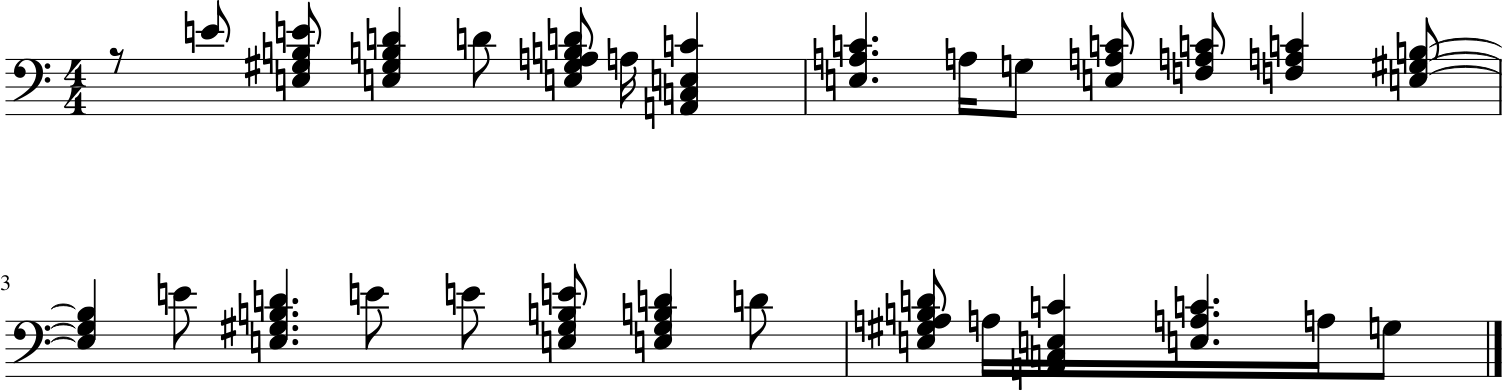

In [60]:
ns.show()

In [61]:
str2seq(pred_only)

[[],
 [],
 [E4t2],
 [],
 [E3t2, G#3t2, B3t2, E4t2],
 [],
 [E3t4, G#3t4, B3t4, D4t2, D4t4],
 [],
 [D4t2],
 [],
 [E3t2, G#3t2, A3t1, B3t2, D4t10],
 [A3t1],
 [A2t4, C3t4, E3t4, C4t9],
 [],
 [],
 [],
 [E3t6, A3t6, C4t6],
 [],
 [],
 [A3t1],
 [G3t2],
 [],
 [E3t2, A3t2, A3t2, C4t2],
 [],
 [F3t2, A3t10, A3t2, C4t2],
 [],
 [F3t4, A3t4, C4t4],
 [],
 [],
 [],
 [E3t6, G#3t6, B3t6],
 [],
 [],
 [],
 [E4t2],
 [],
 [E3t6, G#3t6, B3t6, D4t2, D4t6],
 [],
 [E4t2],
 [],
 [E4t2],
 [],
 [E3t2, G#3t2, B3t2, E4t2],
 [],
 [E3t4, G#3t4, B3t4, D4t2, D4t4],
 [],
 [D4t2],
 [],
 [E3t2, G#3t2, A3t1, B3t2, D4t10],
 [A3t1],
 [A2t4, C3t4, E3t4, C4t9],
 [],
 [],
 [],
 [E3t6, A3t6, C4t6],
 [],
 [],
 [A3t1],
 [G3t2]]

In [62]:
ns = str2stream(pred_out)
ns.show('midi')

### Fastai beam search

In [117]:
[h.shape for h in learn.model[0].hidden]

[torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410])]

In [25]:
pred_out = learn.beam_search(seed, n_words=200); pred_out

'|| t12 nE5 t2 || t1 nG5 t2 || t1 nA2 t12 nC3 t12 nE3 t12 nA5 t4 || t11 nG3 t4 nB3 t4 nD4 t4 nG5 t2 || t1 nE5 t2 || t1 nC3 t16 nE3 t16 nG3 t16 nE5 t4 || t11 nE5 t2 || t1 nG5 t2 || t1 nA2 t12 nC3 t12 nE3 t12 nA5 t4 || t3 nA5 t4 || t3 nA5 t3 || t2 nG5 t3 || t0 nG3 t4 nB3 t4 nD4 t4 || t12 nE5 t2 || t1 nG5 t2 || t1 nA2 t12 nC3 t12 nE3 t12 nA5 t4 || t11 nG3 t4 nB3 t4 nD4 t4 nG5 t2 || t1 nE5 t2 || t1 nC3 t16 nE3 t16 nG3 t16 nE5 t4 || t11 nE5 t2 || t1 nG5 t2 || t1 nA2 t12 nC3 t12 nE3 t12 nA5 t4 || t3 nA5 t4 || t3 nA5 t3 || t2 nG5 t3 || t0 nG3 t4 nB3 t4 nD4 t4 || t1 nE5 t2 || t1 nC3 t16 nE3 t16 nG3 t16 nE5 t4 || t11 nE5 t2 || t1 nG5 t2 || t1 nA2 t12 nC3 t12 nE3 t12 nA5 t4 || t3 nA5 t4 || t3 nA5 t3 || t2 nG5 t3 || t0 nG3 t4 nB3 t4 nD4 t4 || t1 nE5 t2 || t1 nC3 t16 nE3 t16 nG3 t16 nE5 t4 || t11 nE5 t2 || t1 nG5 t2 || t1 nA2 t12 nC3 t12 nE3 t12 nA5 t4 || t3 nA5 t4 || t3 nA5 t3 || t2 nG5 t3 || t0 nG3 t4 nB3 t4 nD4 t4 || t1 nE5 t2 || t1 nC3 t16 nE3 t16 nG3 t16 nE5 t4 || t11 nE5 t2 || t1 nG5 t2 || t

In [26]:
xb,yb = learn.data.one_item(seed)

In [27]:
xb.shape

torch.Size([1, 80])

### Beam search

In [63]:
from beam_search import *

In [64]:
pred_beam, idxs = beam_search(seed, seq_length=200, beam_size=4, learn=learn, temperature=1)
pred_beam_only = pred_beam.replace(seed, '').strip(); pred_beam_only

'|| t0 nE5 t2 || t0 nD5 t1 || t0 nC5 t1  || t0 nE5 t2 || t0 nD5 t1 || t0 nC5 t1 || t0 nA2 t4 nC3 t4 nE3 t4 nE4 t2 || t1 nE4 t2 || t1 nE3 t2 nA3 t2 nC4 t2 nC4 t2 || t1 nE3 t2 nA3 t2 nC4 t2 nC4 t2 || t1 nF3 t2 nA3 t10 nA3 t2 nC4 t2 || t1 nF3 t4 nA3 t4 nC4 t4 || t3 nE3 t6 nG#3 t6 nB3 t6 xxbos || t0 nA2 t16 nC3 t16 nE3 t16 nA4 t2 || t1 nA4 t2 || t1 nA4 t2 || t1 nA4 t2 || t1 nA4 t2 || t1 nA4 t2 || t1 nA4 t2 ||'

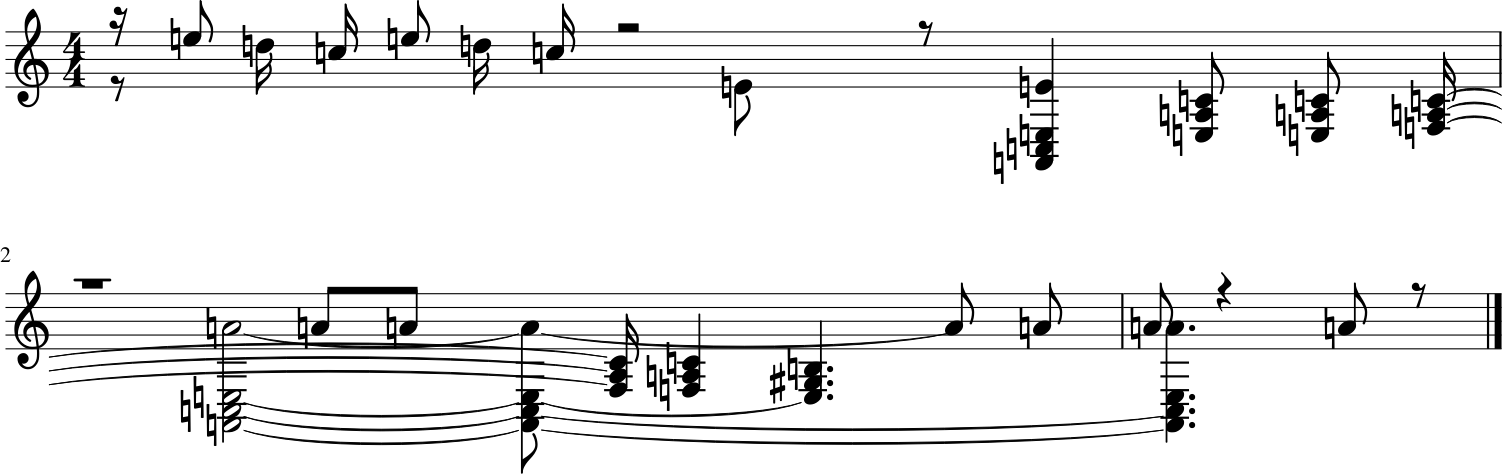

In [65]:
ns_only = str2stream(pred_beam_only).show()

In [66]:
ns_only = str2stream(pred_beam_only)
ns_only.show('midi')

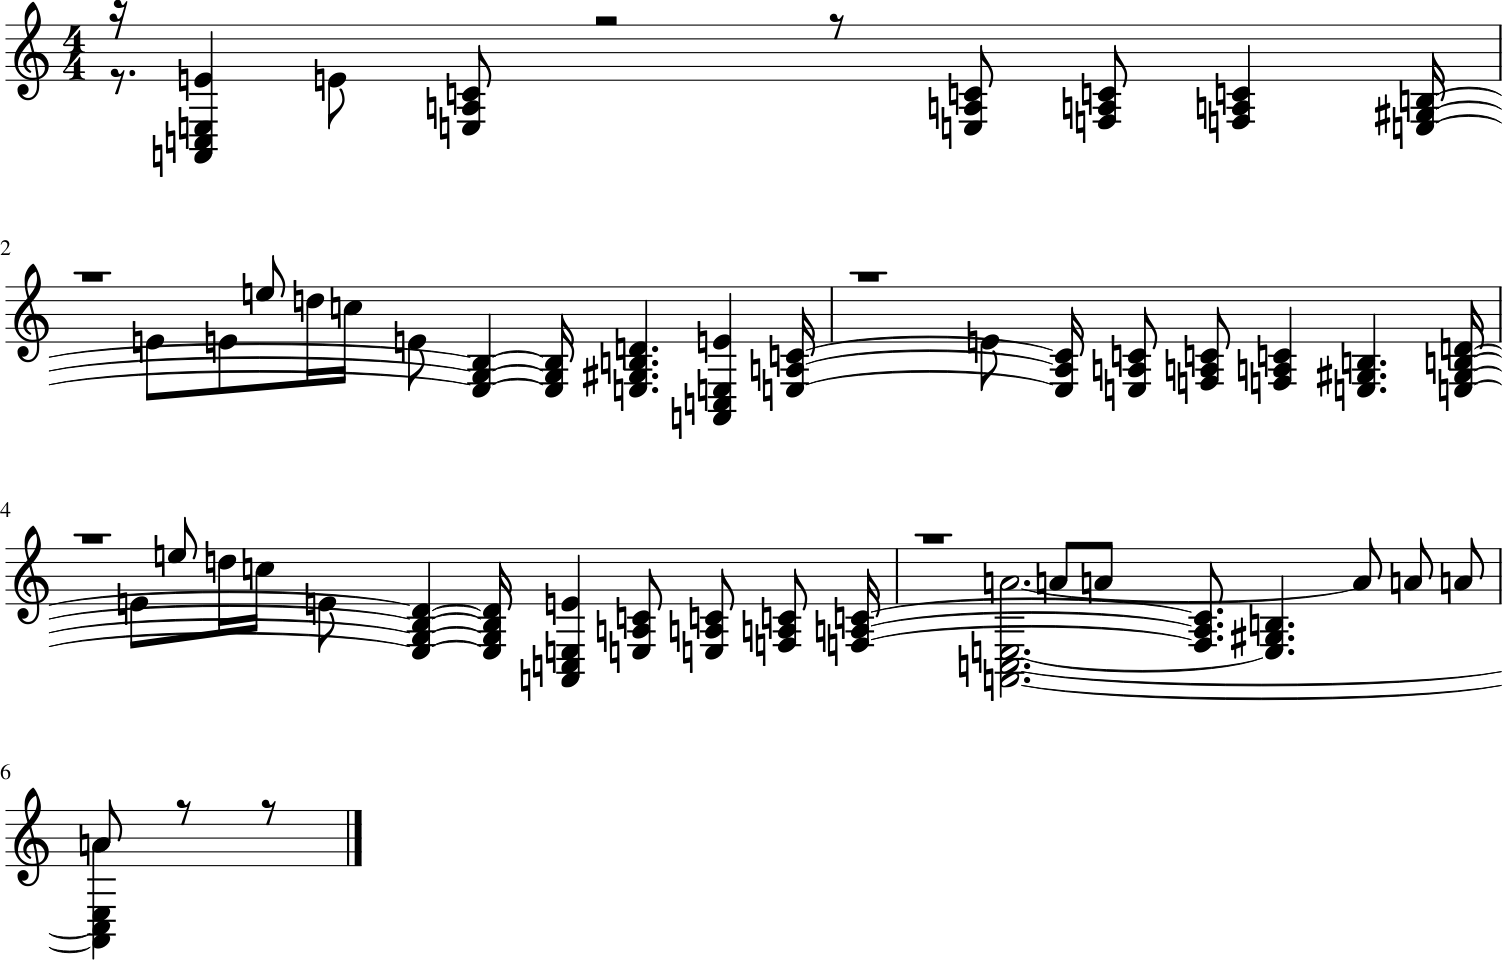

In [67]:
ns = str2stream(pred_beam).show()

In [68]:
ns = str2stream(pred_beam)
ns.show('midi')